In [2]:
# Install required dependencies
!pip install camelot-py[base]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import camelot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
source_dir = "/content/drive/MyDrive/SI 671 - Final Project Data/"

Mounted at /content/drive


# Data Preprocessing

In [ ]:
fire_incidents = pd.read_csv(f"{source_dir}incidents-ca-fires-other.csv")
print(fire_incidents.columns)
print("Total Incidents: ", len(fire_incidents))
fire_incidents.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SI 671 - Final Project Data/incidents-ca-fires-other.csv'

In [ ]:
# Read ZCTA file to obtain zip codes
zcta = gpd.read_file(f"{source_dir}tl_2024_us_zcta520/tl_2024_us_zcta520.shp")

ca_zcta = zcta[zcta['ZCTA5CE20'].str.startswith(('90', '91', '92', '93', '94', '95', '96'))]
print(f"Number of CA ZCTAs: {len(ca_zcta)}")
print(f"Columns: {ca_zcta.columns.tolist()}")

print(f"\nMissing latitude: {fire_incidents['incident_latitude'].isna().sum()}")
print(f"Missing longitude: {fire_incidents['incident_longitude'].isna().sum()}")

In [ ]:
fire_incidents.columns

In [ ]:
# geometry = [Point(xy) for xy in zip(fire_incidents['incident_longitude'], fire_incidents['incident_latitude'])]
# fire_gdf = gpd.GeoDataFrame(fire_incidents, geometry = geometry)

fire_gdf = gpd.GeoDataFrame(
    fire_incidents,
    geometry=gpd.points_from_xy(
        fire_incidents['incident_longitude'],
        fire_incidents['incident_latitude']
    ),
    crs="EPSG:4326"
)

if fire_gdf.crs != ca_zcta.crs:
    fire_gdf = fire_gdf.to_crs(ca_zcta.crs)

fires_with_zip = gpd.sjoin_nearest(fire_gdf, ca_zcta, how='left')
fires_with_zip = fires_with_zip.rename(columns={'ZCTA5CE20': 'zip_code'})

matched = fires_with_zip['zip_code'].notna().sum()
unmatched = fires_with_zip['zip_code'].isna().sum()

print(f"Matched to ZIP: {matched} ({matched/len(fires_with_zip)*100:.1f}%)")
print(f"Not matched: {unmatched} ({unmatched/len(fires_with_zip)*100:.1f}%)")

In [ ]:
def extract_table_from_pdfs(pdf_path, set_flavor='lattice', cols_to_skip = 4,  sub_categories=5):
    try:
      print("Exttracting data from pdf...")
      pdf_tables = camelot.read_pdf(pdf_path, pages="all", flavor=set_flavor)
      print(f"Dataframe created frome {pdf_path}")
    except Exception as e:
      print(f"{set_flavor} not found - table might be without borders: {e}")

    df_list = []
    for table in pdf_tables:
        df_list.append(table.df)

    df = pd.concat(df_list)
    df.columns = df.iloc[1]
    df = df.iloc[2:].reset_index(drop=True)
    mask = df['Zip'].astype(str).str.upper().isin(['ZIP', 'ZIP_CODE', 'ZIP CODE'])
    df = df[~mask]

    new_cols = []

    for i in range(len(df.columns)):
      if i < cols_to_skip:
        new_cols.append(df.columns[i])  # First 4 columns unchanged
        continue
      category_idx = (i - 4) // sub_categories
      categories = ['Low', 'Medium', 'High']
      category = categories[category_idx]
      subcol = df.columns[i]
      new_cols.append(f"{category}_{subcol}")

    df.columns = new_cols

    df = df.dropna(how='all')
    df = df.reset_index(drop=True)
    non_numeric = ['Zip', 'ZIP_Code', 'County', 'Is Distressed Area', 'Region']
    for col in df.columns:
        if col not in non_numeric:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df =  df[df['Zip'].str.strip() != '']

    return df

In [ ]:
res_policy_counts = extract_table_from_pdfs(f"{source_dir}residential-policy-count.pdf")
res_policy_premium = extract_table_from_pdfs(f"{source_dir}residential-policy-premium.pdf")
res_policy_exposure = extract_table_from_pdfs(f"{source_dir}residential-policy-exposure.pdf")
com_policy_counts = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-count.pdf", sub_categories=6)
com_policy_premium = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-premium.pdf", sub_categories=6)
com_policy_exposure = extract_table_from_pdfs(f"{source_dir}commercial-under20-policy-exposure.pdf", sub_categories=6)

In [ ]:
res_policy_premium.columns

In [ ]:
def extract_table_from_growth_pdfs(pdf_path, set_flavor='lattice',policy_metric='Exposure', rows_to_skip=2):
  try:
      print("Exttracting data from pdf...")
      pdf_tables = camelot.read_pdf(pdf_path, pages="all", flavor=set_flavor)
      print(f"Dataframe created frome {pdf_path}")
  except Exception as e:
    print(f"{set_flavor} not found - table might be without borders: {e}")

  df_list = []
  for table in pdf_tables:
      df_list.append(table.df)

  df = pd.concat(df_list)
  df.columns = df.iloc[rows_to_skip]
  df = df.iloc[rows_to_skip:].reset_index(drop=True)
  empty_cols = [col for col in df.columns if col == '']
  df = df.drop(columns=empty_cols)

  if len(df.columns)==11:
    df.columns = ['ZIP_Code', 'Growth_2025', f'Total_{policy_metric}_2025', 'Growth_2024', f'Total_{policy_metric}_2024',
               'Growth_2023', f'Total_{policy_metric}_2023', 'Growth_2022', f'Total_{policy_metric}_2022',
               'Growth_2021', f'Total_{policy_metric}_2021']
  else:
    print("Inspect columns:\n")
    print(df.columns)
    return

  df['ZIP_Code'] = df['ZIP_Code'].astype(str)

  for col in df.columns[1:]:
    if 'Growth' in col:
      # Remove percentage signs and convert to decimal
      df[col] = df[col].astype(str).str.replace('%', '', regex=False)
    elif 'Exposure' in col:
      # Remove dollar signs, newlines, and commas
      df[col] = df[col].astype(str).str.replace(r'[\$\n,]', '', regex=True)

    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

  df =  df[df['ZIP_Code'].str.strip() != '']
  df = df.dropna(subset=['ZIP_Code'])
  df = df.drop_duplicates(subset=[zip_col], keep='first')
  df = df.drop([0, 1]).reset_index(drop=True)

  return df

In [ ]:
com_pif_growth = extract_table_from_growth_pdfs(f"{source_dir}commercial-pif-yoy-zip.pdf", set_flavor='stream',policy_metric='PIFs')
res_pif_growth = extract_table_from_growth_pdfs(f"{source_dir}residential-pif-yoy-zip.pdf",set_flavor='stream',policy_metric='PIFs')
com_exp_growth = extract_table_from_growth_pdfs(f"{source_dir}commercial-exposure-yoy-zip.pdf",set_flavor='stream',policy_metric='Exposure', rows_to_skip=3)
res_exp_growth = extract_table_from_growth_pdfs(f"{source_dir}residential-exposure-yoy-zip.pdf", set_flavor='stream',policy_metric='Exposure')

In [ ]:
print("="*70)
print("DIAGNOSING GROWTH DATASET DUPLICATES")
print("="*70)

# Check each growth dataset for duplicates
for name, df in [
    ('res_pif_growth', res_pif_growth),
    ('res_exp_growth', res_exp_growth),
    ('com_pif_growth', com_pif_growth),
    ('com_exp_growth', com_exp_growth)
]:
    total_rows = len(df)

    # Find zip column
    zip_col = 'ZIP_Code' if 'ZIP_Code' in df.columns else 'zip_code'

    unique_zips = df[zip_col].nunique()
    duplicates = total_rows - unique_zips

    print(f"\n{name}:")
    print(f"  Total rows: {total_rows}")
    print(f"  Unique ZIPs: {unique_zips}")
    print(f"  Duplicate rows: {duplicates}")

    if duplicates > 0:
        # Show which ZIPs are duplicated
        dup_counts = df[df.duplicated(subset=[zip_col], keep=False)].groupby(zip_col).size()
        print(f"  Most duplicated ZIPs:")
        print(dup_counts.sort_values(ascending=False).head(10))

In [ ]:
fair_datasets = (
    res_policy_counts, res_policy_exposure, res_policy_premium, com_policy_counts, com_policy_exposure, com_policy_premium
    )
growth_datasets = (
    com_pif_growth, com_exp_growth, res_pif_growth, res_exp_growth
)

if 'index_right' in fires_with_zip.columns:
    fires_with_zip = fires_with_zip.drop(columns=['index_right'])

def create_master_dataset(fires_df, ca_zipcodes,
                          fair_datasets, growth_datasets):

    master_gdf = ca_zipcodes.copy()
    master_gdf['zip_code'] = master_gdf['ZCTA5CE20']

    # 2. Add geometric features
    master_gdf['centroid'] = master_gdf.geometry.centroid
    master_gdf['centroid_lat'] = master_gdf.centroid.y
    master_gdf['centroid_lon'] = master_gdf.centroid.x
    master_gdf['area_sq_miles'] = master_gdf.geometry.area / 2589988.11  # Convert to sq miles

    # 3. Process and join fire data
    fire_features = create_fire_features(fires_df, master_gdf)
    master_gdf = master_gdf.merge(fire_features, on='zip_code', how='left')

    # 4. Join FAIR plan current state
    fair_current = merge_fair_current_state(fair_datasets)
    master_gdf = master_gdf.merge(fair_current, on='zip_code', how='left')

    # 5. Join growth metrics
    growth_features = process_growth_metrics(growth_datasets)
    master_gdf = master_gdf.merge(growth_features, on='zip_code', how='left')

    cols_to_drop = ['ZCTA5CE20', 'GEOID20', 'GEOIDFQ20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'area_sq_miles_y',
      'County_exposure', 'Is Distressed Area_exposure', 'Region_exposure', 'County_counts', 'Is Distressed Area_counts', 'Region_counts', 'County_counts',
      'Is Distressed Area_counts', 'Region_counts', 'County_premium', 'Is Distressed Area_premium', 'Region_premium', 'County_exposure', 'Is Distressed Area_exposure',
      'Region_exposure']

    master_gdf = master_gdf.drop(cols_to_drop, axis=1)

    cols = ['zip_code'] + [col for col in master_df.columns if col != 'zip_code']
    master_gdf = master_gdf[cols]

    return master_gdf

def create_fire_features(fires_df, zip_gdf):

    # Spatial join
    fires_zip_tmp = gpd.sjoin(fires_df, zip_gdf[['zip_code', 'geometry']],
                                how='left', predicate='within')

    if 'zip_code_left' in fires_zip_tmp.columns and 'zip_code_right' in fires_zip_tmp.columns:
      # Check how many differ
      matches = (fires_zip_tmp['zip_code_left'] == fires_zip_tmp['zip_code_right']).sum()
      total = len(fires_zip_tmp)
      print(f"ZIP codes match: {matches}/{total} ({matches/total*100:.1f}%)")

      # See mismatches
      mismatches = fires_zip_tmp[
          fires_zip_tmp['zip_code_left'] != fires_zip_tmp['zip_code_right']
      ][['incident_name', 'zip_code_left', 'zip_code_right', 'geometry', 'incident_latitude', 'incident_longitude']]

    if len(mismatches) > 0:
        print(f"\n{len(mismatches)} fires have different ZIP codes:")
        print(mismatches.head(10))

    fires_zip_tmp['zip_code'] = fires_zip_tmp['zip_code_right']

    # Drop both old columns
    fires_zip_tmp = fires_zip_tmp.drop(columns=['zip_code_left', 'zip_code_right'])

    # Add year column
    fires_zip_tmp['year'] = pd.to_datetime(
        fires_zip_tmp['incident_dateonly_created']
    ).dt.year

    print(fires_zip_tmp.columns)
    # Aggregate by ZIP
    fire_agg = fires_zip_tmp.groupby('zip_code').agg({
        'incident_id': 'count',
        'incident_acres_burned': ['sum', 'mean', 'max'],
        'incident_dateonly_created': ['min', 'max'],
        'incident_containment': 'mean'
    }).reset_index()

    fire_agg.columns = ['_'.join(col).strip('_') for col in fire_agg.columns.values]

    fire_agg = fire_agg.rename(columns={
        'incident_id_count': 'total_fire_incidents',
        'incident_acres_burned_sum': 'total_acres_burned',
        'incident_acres_burned_mean': 'avg_acres_per_fire',
        'incident_acres_burned_max': 'max_acres_burned',
        'incident_dateonly_created_min': 'first_fire_date',
        'incident_dateonly_created_max': 'last_fire_date',
        'incident_containment_mean': 'avg_containment_pct'
    })

    # Recent activity
    current_date = datetime.now()
    for years_back in [1, 2, 3 , 4, 5]:
        cutoff = current_date - pd.DateOffset(years=years_back)
        recent = fires_zip_tmp[
            pd.to_datetime(fires_zip_tmp['incident_dateonly_created']) >= cutoff
        ]
        counts = recent.groupby('zip_code').size().rename(f'fires_last_{years_back}yr')
        fire_agg = fire_agg.merge(counts, on='zip_code', how='left')

    # Year-by-year counts
    yearly = fires_zip_tmp.groupby(['zip_code', 'year']).agg({
        'incident_id': 'count',
        'incident_acres_burned': 'sum'
    }).reset_index()

    for year in range(2021, 2026):
        year_data = yearly[yearly['year'] == year][['zip_code', 'incident_id']]
        year_data = year_data.rename(columns={'incident_id': f'fire_count_{year}'})
        fire_agg = fire_agg.merge(year_data, on='zip_code', how='left')

        acres_data = yearly[yearly['year'] == year][['zip_code', 'incident_acres_burned']]
        acres_data = acres_data.rename(columns={'incident_acres_burned': f'acres_burned_{year}'})
        fire_agg = fire_agg.merge(acres_data, on='zip_code', how='left')


    # Calculate fire density
    fire_agg = fire_agg.merge(
        zip_gdf[['zip_code', 'area_sq_miles']],
        on='zip_code'
    )
    fire_agg['fire_density'] = (
        fire_agg['total_fire_incidents'] / fire_agg['area_sq_miles']
    )

    return fire_agg

def merge_fair_current_state(fair_datasets):
    """
    Merge all FAIR datasets for current state
    """
    (res_policy_counts, res_policy_exposure, res_policy_premium,
     com_policy_counts, com_policy_exposure, com_policy_premium) = fair_datasets

    fair_merged = res_policy_counts.merge(res_policy_exposure, on='Zip', how='outer', suffixes=('_counts', '_exposure'))
    print(f"Starting with {len(fair_merged)} unique ZIP codes")

    fair_merged = fair_merged.merge(res_policy_premium, on='Zip', how='outer', suffixes=('', '_premium'))
    print(f"After res_premium: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_counts, on='Zip', how='outer', suffixes=('', '_counts'))
    print(f"After com_counts: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_premium, on='Zip', how='outer', suffixes=('', '_premium'))
    print(f"After com_premium: {len(fair_merged)} rows")

    fair_merged = fair_merged.merge(com_policy_exposure, on='Zip', how='outer', suffixes=('', '_exposure'))
    print(f"After com_exposure: {len(fair_merged)} rows")

    fair_merged = fair_merged.rename(columns={'Zip': 'zip_code'})

    return fair_merged

def process_growth_metrics(growth_datasets):
    """
    Process year-over-year growth data
    """
    (com_pif_growth, com_exp_growth, res_pif_growth, res_exp_growth) = growth_datasets

    growth_merged = res_pif_growth.rename(columns={
        'ZIP_Code': 'zip_code',
        'Growth_2025': 'res_policy_growth_pct_2024_2025',  # Growth from 2024 to 2025 and similarly
        'Total_PIFs_2025': 'res_policy_count_2025',
        'Growth_2024': 'res_policy_growth_pct_2023_2024',
        'Total_PIFs_2024': 'res_policy_count_2024',
        'Growth_2023': 'res_policy_growth_pct_2022_2023',
        'Total_PIFs_2023': 'res_policy_count_2023',
        'Growth_2022': 'res_policy_growth_pct_2021_2022',
        'Total_PIFs_2022': 'res_policy_count_2022',
        'Growth_2021': 'res_policy_growth_pct_2020_2021',
        'Total_PIFs_2021': 'res_policy_count_2021'
    })

    # growth_merged = res_pif_growth.copy(
    print(f"After res_policy: {len(growth_merged)} rows, {len(growth_merged.columns)}")

    rename_dict = {}
    for col in res_exp_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'res_exposure_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'res_exposure_total_{year}'

    res_exp_growth = res_exp_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(res_exp_growth, on='zip_code', how='outer')
    print(f"After res_exposure: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    rename_dict = {}
    for col in com_pif_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'com_policy_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'com_policy_count_{year}'

    com_pif_growth = com_pif_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(com_pif_growth, on='zip_code', how='outer')
    print(f"After com_policy: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    rename_dict = {}
    for col in com_exp_growth.columns:
        if col == 'ZIP_Code':
            rename_dict[col] = 'zip_code'
        elif 'Growth_' in col:
            year = col.split('_')[1]
            prev_year = str(int(year) - 1)
            rename_dict[col] = f'com_exposure_growth_pct_{prev_year}_{year}'
        elif 'Total_' in col:
            year = col.split('_')[-1]
            rename_dict[col] = f'com_exposure_total_{year}'

    com_exp_renamed = com_exp_growth.rename(columns=rename_dict)

    growth_merged = growth_merged.merge(com_exp_renamed, on='zip_code', how='outer')
    print(f"After com_exposure: {len(growth_merged)} rows, {len(growth_merged.columns)} columns")

    return growth_merged

master_df = create_master_dataset(fires_with_zip, ca_zcta, fair_datasets, growth_datasets)

In [ ]:
master_df.tail()

In [ ]:
master_df.to_csv(f"{source_dir}master_combined_data.csv", index=False)

# RNN - LSTM for TSA

In [5]:
master_df = pd.read_csv(f"{source_dir}master_combined_data.csv")
for col in master_df.columns:
  print(col)

zip_code
geometry
centroid
centroid_lat
centroid_lon
area_sq_miles_x
total_fire_incidents
total_acres_burned
avg_acres_per_fire
max_acres_burned
first_fire_date
last_fire_date
avg_containment_pct
fires_last_1yr
fires_last_2yr
fires_last_3yr
fires_last_4yr
fires_last_5yr
fire_count_2021
acres_burned_2021
fire_count_2022
acres_burned_2022
fire_count_2023
acres_burned_2023
fire_count_2024
acres_burned_2024
fire_count_2025
acres_burned_2025
fire_density
Low_Owner-occupied Single Family Residential_counts
Low_Tenant-occupied_counts
Low_Renters_counts
Low_Condo unit-owners_counts
Low_Other_counts
Low_Other_counts.1
Medium_Owner-occupied Single Family Residential_counts
Medium_Tenant-occupied_counts
Medium_Renters_counts
Medium_Condo unit-owners_counts
Medium_Other_counts
Medium_Other_counts.1
High_Owner-occupied Single Family Residential_counts
High_Tenant-occupied_counts
High_Renters_counts
High_Condo unit-owners_counts
High_Other_counts
High_Other_counts.1
Low_Owner-occupied Single Family 

In [ ]:
def prepare_lstm_data(master_df, target_col='res_policy_count', lookback=3, scale_data=True):
    """
    Prepare data to fit in LSTM model
    """
    # Get all ZIPs with complete data
    all_sequences = []
    all_targets = []

    years = [2021, 2022, 2023, 2024, 2025]

    for idx, row in master_df.iterrows():
        # Extract time series for this ZIP
        series = [row[f'{target_col.split("_")[0]}_{target_col.split("_")[1]}_{target_col.split("_")[2]}_{year}']
                  for year in years]

        missing_sum = pd.Series(series).isna().sum()
        if missing_sum > 5:
          print(f"Missing values in idx {idx} are: {missing_sum}")

        # Fill any remaining NaN with forward fill
        series = pd.Series(series).fillna(method='ffill').fillna(0).values

        # Create sequences
        for i in range(len(series) - lookback):
            all_sequences.append(series[i:i+lookback])
            all_targets.append(series[i+lookback])

    X = np.array(all_sequences)
    y = np.array(all_targets)

    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y



def build_lstm_model(lookback=3):
    """
    Build LSTM model
    """

    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


In [ ]:
X, y = prepare_lstm_data(master_df, target_col='res_policy_count', lookback=3)

split = int(0.85 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Build and train model
lstm_model = build_lstm_model(lookback=3)

Training samples: 3247
Test samples: 573


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop if no improvement for 10 epochs
    restore_best_weights=True,  # Restore weights from best epoch
    verbose=1
    )

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],  # Add callback here
    verbose=1
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 70628.9844 - mae: 146.5279 - val_loss: 23014.8223 - val_mae: 90.6062
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 10444.7422 - mae: 55.2893 - val_loss: 11228.7637 - val_mae: 64.3456
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8853.3438 - mae: 51.7256 - val_loss: 10796.1318 - val_mae: 59.6592
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6131.7476 - mae: 41.9049 - val_loss: 12231.8008 - val_mae: 63.9968
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7778.9336 - mae: 44.5805 - val_loss: 6670.8677 - val_mae: 49.9903
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6012.5635 - mae: 41.7755 - val_loss: 6964.9331 - val_mae: 47.0300
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4617.5474 - mae: 34.7172 - val_loss: 7370.1113 - val_mae: 49.8872
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4958.3789 - mae: 36.1362 - val_loss: 6153.3735 - val_mae: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6274.0498 - mae: 43.7463

Test MAE: 42.32


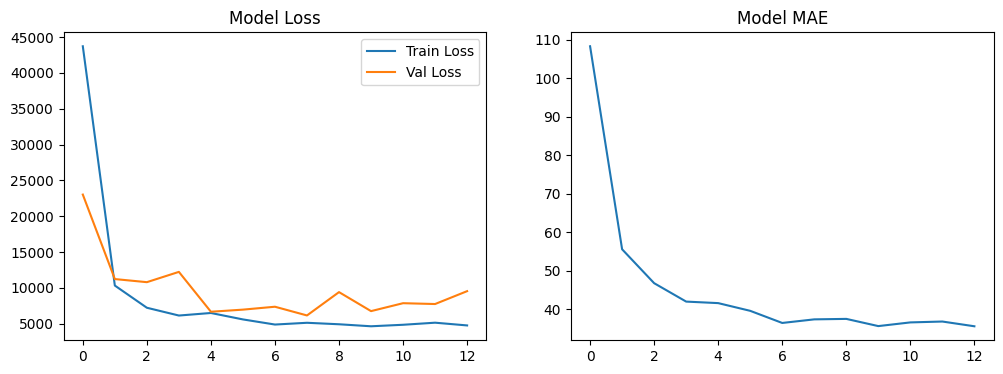

In [ ]:
# Evaluate
test_loss, test_mae = lstm_model.evaluate(X_test, y_test)
print(f"\nTest MAE: {test_mae:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
# plt.plot(history.history['val_mae'], label='Val MAE')
# plt.legend()
plt.title('Model MAE')
plt.show()

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 373120095519506432.0000 - mae: 231412832.0000 - val_loss: 96808691700858880.0000 - val_mae: 155997392.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69340022200860672.0000 - mae: 100000336.0000 - val_loss: 93706230664527872.0000 - val_mae: 157101616.0000
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 109664602559610880.0000 - mae: 112778080.0000 - val_loss: 102314461817208832.0000 - val_mae: 161667664.0000
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 68245076123320320.0000 - mae: 98703464.0000 - val_loss: 94995030090973184.0000 - val_mae: 155946832.0000
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93419481467977728.0000 - mae: 99758040.0000 - val_loss: 94028851427934208.0000 - val_mae: 155279984.0000
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47720063070896128.0000 - mae: 84694144.0000 - val_loss: 7844735432314060

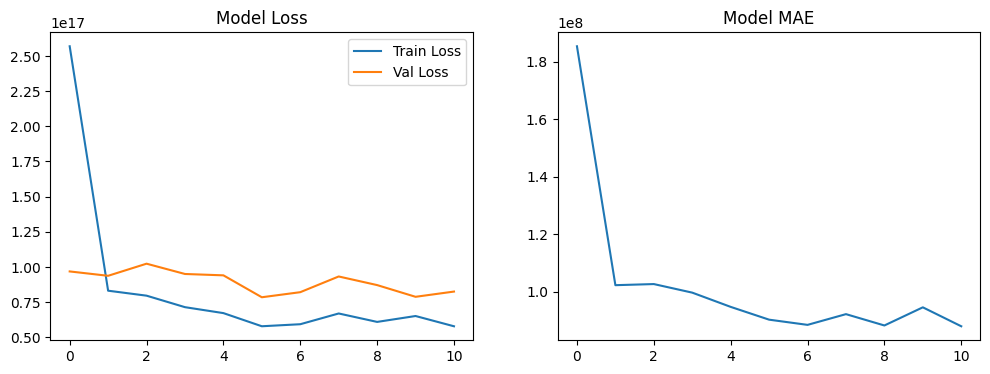

In [ ]:
def run_lstm_on_data(col_label = 'res_policy_count'):
  X, y = prepare_lstm_data(master_df, target_col= col_label, lookback=3)

  split = int(0.85 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  print(f"Training samples: {len(X_train)}")
  print(f"Test samples: {len(X_test)}")

  # Build and train model
  lstm_model = build_lstm_model(lookback=3)

  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,             # Stop if no improvement for 10 epochs
      restore_best_weights=True,  # Restore weights from best epoch
      verbose=1
      )

  history = lstm_model.fit(
      X_train, y_train,
      epochs=100,
      batch_size=32,
      validation_split=0.2,
      callbacks=[early_stop],
      verbose=1
  )

  test_loss, test_mae = lstm_model.evaluate(X_test, y_test)
  print(f"\nTest MAE: {test_mae:.2f}")

  # Plot training history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.legend()
  plt.title('Model Loss')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['mae'], label='Train MAE')
  # plt.plot(history.history['val_mae'], label='Val MAE')
  # plt.legend()
  plt.title('Model MAE')
  plt.show()


run_lstm_on_data('res_exposure_total')

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 295.4752 - mae: 7.5507 - val_loss: 89.6562 - val_mae: 4.6639
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 71.2469 - mae: 3.9869 - val_loss: 64.6188 - val_mae: 3.9670
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 67.9931 - mae: 3.7948 - val_loss: 58.2337 - val_mae: 3.6531
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47.9640 - mae: 3.2631 - val_loss: 35.6748 - val_mae: 3.4293
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.4060 - mae: 3.0982 - val_loss: 30.2278 - val_mae: 3.3312
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.9224 - mae: 2.9978 - val_loss: 17.3493 - val_mae: 2.6555
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.9636 - mae: 2.9182 - val_loss: 40.5846 - val_mae: 3.0196
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.6812 - mae: 3.1224 - val_loss: 23.9179 - val_mae: 2.8043
Epoc

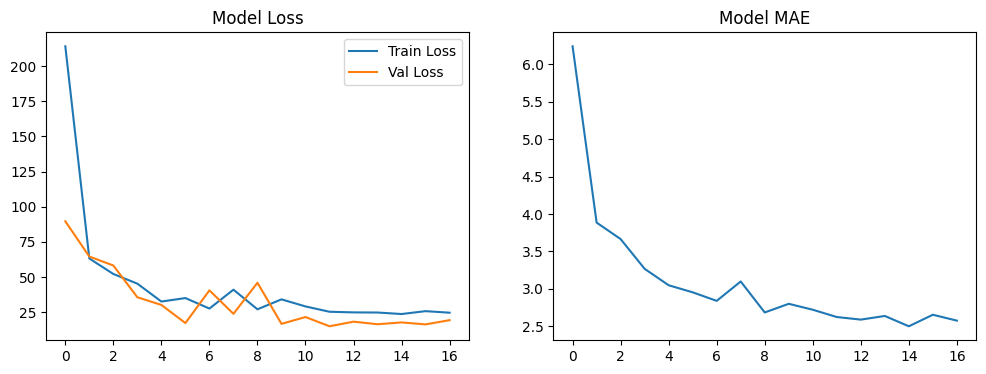

In [ ]:
run_lstm_on_data('com_policy_count')

Training samples: 3247
Test samples: 573
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2069784199954432.0000 - mae: 17285386.0000 - val_loss: 754232495964160.0000 - val_mae: 12560182.0000
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 728881652826112.0000 - mae: 10873652.0000 - val_loss: 750258443255808.0000 - val_mae: 11632041.0000
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 468405106769920.0000 - mae: 9509013.0000 - val_loss: 630349063258112.0000 - val_mae: 11369824.0000
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 483339815354368.0000 - mae: 9448428.0000 - val_loss: 560378207535104.0000 - val_mae: 11320433.0000
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 443446749822976.0000 - mae: 8898457.0000 - val_loss: 506368188481536.0000 - val_mae: 10014778.0000
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 323377214521344.0000 - mae: 8175342.5000 - val_loss: 426361437028352.0000 - val_mae: 9761545.0000
Epoch 7

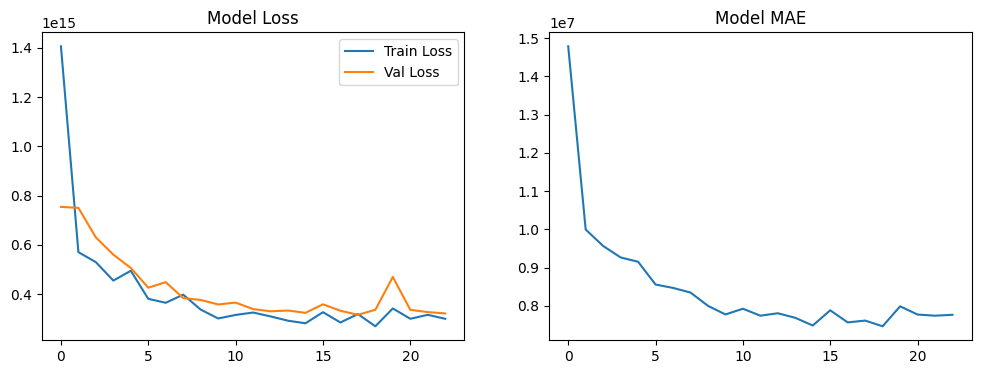

In [ ]:
run_lstm_on_data('com_exposure_total')

In [6]:
def create_panel_data(master_df):
    """Convert wide format to panel (ZIP × Year)"""
    years = [2021, 2022, 2023, 2024, 2025]
    panel = []

    for _, row in master_df.iterrows():
        for year in years:
            panel.append({
                'zip_code': row['zip_code'],
                'year': year,

                # Fire features
                'fire_count': row.get(f'fire_count_{year}', 0),
                'acres_burned': row.get(f'acres_burned_{year}', 0),
                'fire_density': row.get('fire_density', 0),
                'total_fires': row.get('total_fire_incidents', 0),

                # Residential
                'res_policy': row.get(f'res_policy_count_{year}', 0),
                'res_exposure': row.get(f'res_exposure_total_{year}', 0),
                'res_low_income': row.get('Low_Owner-occupied Single Family Residential_counts', 0),
                'res_medium_income': row.get('Medium_Owner-occupied Single Family Residential_counts', 0),
                'res_high_income': row.get('High_Owner-occupied Single Family Residential_counts', 0),

                # Commercial
                'com_policy': row.get(f'com_policy_count_{year}', 0),
                'com_exposure': row.get(f'com_exposure_total_{year}', 0),
                'com_retail': row.get('Low_Retail', 0) + row.get('Medium_Retail', 0) + row.get('High_Retail', 0),
                'com_office': row.get('Low_Office Buildings', 0) + row.get('Medium_Office Buildings', 0) + row.get('High_Office Buildings', 0),
                'com_manufacturing': row.get('Low_Manufacturing', 0) + row.get('Medium_Manufacturing', 0) + row.get('High_Manufacturing', 0),
            })

    df = pd.DataFrame(panel)
    return df.replace(0, np.nan).fillna(method='ffill').fillna(0)

In [8]:
for col in master_df.columns:
  print(col)

zip_code
geometry
centroid
centroid_lat
centroid_lon
area_sq_miles_x
total_fire_incidents
total_acres_burned
avg_acres_per_fire
max_acres_burned
first_fire_date
last_fire_date
avg_containment_pct
fires_last_1yr
fires_last_2yr
fires_last_3yr
fires_last_4yr
fires_last_5yr
fire_count_2021
acres_burned_2021
fire_count_2022
acres_burned_2022
fire_count_2023
acres_burned_2023
fire_count_2024
acres_burned_2024
fire_count_2025
acres_burned_2025
fire_density
Low_Owner-occupied Single Family Residential_counts
Low_Tenant-occupied_counts
Low_Renters_counts
Low_Condo unit-owners_counts
Low_Other_counts
Low_Other_counts.1
Medium_Owner-occupied Single Family Residential_counts
Medium_Tenant-occupied_counts
Medium_Renters_counts
Medium_Condo unit-owners_counts
Medium_Other_counts
Medium_Other_counts.1
High_Owner-occupied Single Family Residential_counts
High_Tenant-occupied_counts
High_Renters_counts
High_Condo unit-owners_counts
High_Other_counts
High_Other_counts.1
Low_Owner-occupied Single Family 

In [9]:
len(master_df.columns)

183

In [10]:
redundant_cols = (
    [col for col in master_df.columns if '.1' in col or '.2' in col or '.3' in col] +  # Duplicate Others
    ['geometry', 'centroid', 'first_fire_date', 'last_fire_date'] +  # Geometry and dates
    ['fires_last_1yr', 'fires_last_2yr', 'fires_last_3yr', 'fires_last_4yr', 'fires_last_5yr'] +  # Fire aggregates
    [col for col in master_df.columns if 'growth_pct' in col]  # Growth percentages
)

master_df = master_df.drop(columns=redundant_cols, errors='ignore')
print(f"Dropped {len(redundant_cols)} columns. Remaining: {len(master_df.columns)}")
master_df.to_csv(f"{source_dir}master_combined_data.csv", index=False)

Dropped 47 columns. Remaining: 136


# ZIP Year analysis for single family

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [62]:
# master_df=master_df.fillna(0)
panel = []
years = [2021, 2022, 2023, 2024, 2025]

for _, row in master_df.iterrows():
    static_low_res = row.get('Low_Owner-occupied Single Family Residential_counts', 0)
    static_med_res = row.get('Medium_Owner-occupied Single Family Residential_counts', 0)
    static_high_res = row.get('High_Owner-occupied Single Family Residential_counts', 0)
    static_retail = row.get('Low_Retail', 0)
    static_office = row.get('Low_Office Buildings', 0)

    for year in years:
        panel.append([
            row['zip_code'], year,
            row.get(f'fire_count_{year}', 0),
            row.get(f'acres_burned_{year}', 0),
            row.get(f'res_policy_count_{year}', 0),
            row.get(f'res_exposure_total_{year}', 0),
            row.get(f'com_policy_count_{year}', 0),
            row.get(f'com_exposure_total_{year}', 0),
            static_low_res, static_med_res, static_high_res, static_retail, static_office
        ])

panel_df = pd.DataFrame(panel, columns=['zip', 'year', 'fire_cnt', 'acres', 'res_pol', 'res_exp',
                                        'com_pol', 'com_exp', 'low_inc', 'med_inc', 'high_inc', 'retail', 'office'])

In [54]:
X, y = [], []
for zip_code in panel_df['zip'].unique():
    data = panel_df[panel_df['zip'] == zip_code].iloc[:, 2:].values
    if len(data) < 4: continue
    for i in range(len(data) - 3):
        X.append(data[i:i+3])
        y.append(data[i+3, [2, 3, 4, 5]])

print(f"Length of sequences generated: {len(X)}")

Length of sequences generated: 3820


In [56]:
X, y = np.array(X), np.array(y)
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [57]:
# Check what values exist
print("Sample of master_df:")
print(master_df[['zip_code', 'fire_count_2021', 'fire_count_2022',
                 'res_policy_count_2021', 'res_policy_count_2022',
                 'com_policy_count_2021']].head())

print("\nData summary:")
print(f"Non-zero fire_count_2021: {(master_df['fire_count_2021'] > 0).sum()}")
print(f"Non-zero res_policy_count_2021: {(master_df['res_policy_count_2021'] > 0).sum()}")
print(f"Total rows: {len(master_df)}")

print("\nSample row with actual values:")
sample = master_df[(master_df['fire_count_2021'] > 0) & (master_df['res_policy_count_2021'] > 0)].iloc[0]
print(sample[['zip_code', 'fire_count_2021', 'res_policy_count_2021', 'com_policy_count_2021']])

Sample of master_df:
   zip_code  fire_count_2021  fire_count_2022  res_policy_count_2021  \
0     96777              0.0              0.0                    0.0   
1     96785              0.0              0.0                    0.0   
2     96749              0.0              0.0                    0.0   
3     96760              0.0              0.0                    0.0   
4     96783              0.0              0.0                    0.0   

   res_policy_count_2022  com_policy_count_2021  
0                    0.0                    0.0  
1                    0.0                    0.0  
2                    0.0                    0.0  
3                    0.0                    0.0  
4                    0.0                    0.0  

Data summary:
Non-zero fire_count_2021: 136
Non-zero res_policy_count_2021: 1495
Total rows: 1910

Sample row with actual values:
zip_code                 92505
fire_count_2021            1.0
res_policy_count_2021     51.0
com_policy_count_2021 

In [58]:
inp = Input(shape=(3, X.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True))(inp)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
out = Dense(4)(x)

model = Model(inp, out)
model.compile(Adam(0.001, clipnorm=1.0), loss='mse', metrics=['mae'])

In [59]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)], verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0175 - mae: 0.0629 - val_loss: 0.0100 - val_mae: 0.0508
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0090 - mae: 0.0446 - val_loss: 0.0074 - val_mae: 0.0359
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0066 - mae: 0.0341 - val_loss: 0.0062 - val_mae: 0.0303
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - mae: 0.0317 - val_loss: 0.0054 - val_mae: 0.0311
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - mae: 0.0310 - val_loss: 0.0048 - val_mae: 0.0269
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - mae: 0.0287 - val_loss: 0.0045 - val_mae: 0.0258
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042 - mae: 0.0279 - val_loss: 0.0044 - val_mae: 0.0279
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - mae: 0.0285 - val_loss: 0.0043 - val_mae: 0.0297
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

In [60]:
y_pred = scaler_y.inverse_transform(model.predict(X_test))
y_true = scaler_y.inverse_transform(y_test)

for i, name in enumerate(['Res Policy', 'Res Exposure', 'Com Policy', 'Com Exposure']):
    mae = np.mean(np.abs(y_true[:, i] - y_pred[:, i]))
    print(f"{name} - MAE: {mae:,.0f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Res Policy - MAE: 36
Res Exposure - MAE: 68,158,160
Com Policy - MAE: 2
Com Exposure - MAE: 8,711,735


In [67]:
panel_df['fire_level'] = pd.cut(panel_df.groupby('zip')['fire_cnt'].transform('sum'),
                                 bins=[0, 5, 15, 100], labels=['Low', 'Med', 'High'])
summary = panel_df.groupby('fire_level')[['res_pol', 'com_pol', 'low_inc', 'med_inc', 'high_inc']].mean()
print("\nPolicy counts by fire level:\n", summary)


Policy counts by fire level:
                res_pol    com_pol    low_inc     med_inc    high_inc
fire_level                                                          
Low         147.498283   7.256652  72.060086  106.373391  102.321888
Med         192.793651   7.450794  77.015873   78.507937  165.682540
High         94.533333  14.133333  50.333333  159.666667    2.333333


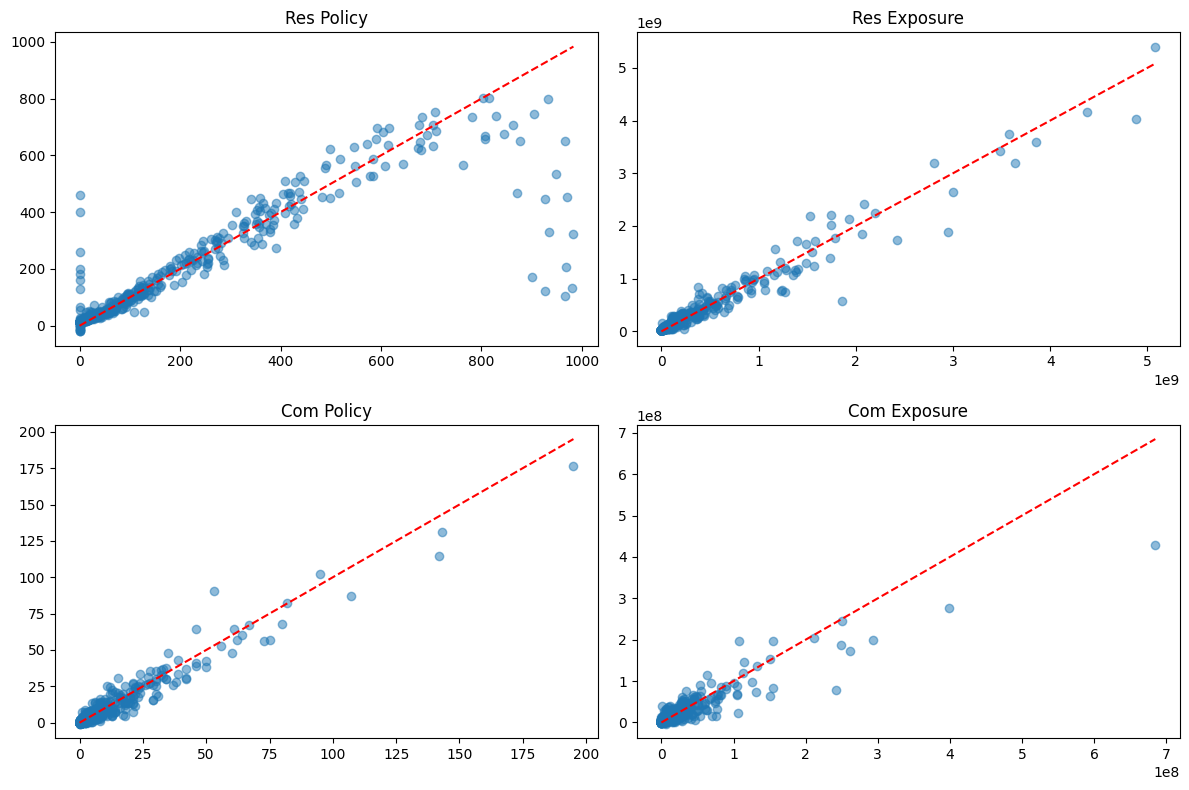

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, name in enumerate(['Res Policy', 'Res Exposure', 'Com Policy', 'Com Exposure']):
    ax = axes[i//2, i%2]
    ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
    ax.plot([y_true[:, i].min(), y_true[:, i].max()], [y_true[:, i].min(), y_true[:, i].max()], 'r--')
    ax.set_title(name)
plt.tight_layout()
plt.show()

# Exposure Mapping

In [74]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [98]:
master_df = pd.read_csv(f"{source_dir}master_combined_data.csv")
len(master_df.columns)

136

In [96]:
# Understanding distribution of data
print("Checking data:")
print(f"Master_df shape: {master_df.shape}")

# Check if exposure columns exist
exposure_cols = [col for col in master_df.columns if 'exposure' in col.lower()]
print(f"\nExposure columns found: {len(exposure_cols)}")
print(exposure_cols[:10])

# Check for non-zero values
print("\nNon-zero values per exposure column:")
for col in exposure_cols[:5]:
    non_zero = (master_df[col] > 0).sum()
    print(f"{col}: {non_zero} non-zero values")

# Check y_train
print(f"\ny_train shape: {y_train.shape}")
print(f"Columns with sum > 0: {(y_train.sum() > 0).sum()}")
print("\nColumns with zero sum:")
zero_cols = y_train.columns[y_train.sum() == 0]
print(zero_cols.tolist())

Checking data:
Master_df shape: (1910, 136)

Exposure columns found: 40
['Low_Owner-occupied Single Family Residential_exposure', 'Low_Tenant-occupied_exposure', 'Low_Renters_exposure', 'Low_Condo unit-owners_exposure', 'Low_Other_exposure', 'Medium_Owner-occupied Single Family Residential_exposure', 'Medium_Tenant-occupied_exposure', 'Medium_Renters_exposure', 'Medium_Condo unit-owners_exposure', 'Medium_Other_exposure']

Non-zero values per exposure column:
Low_Owner-occupied Single Family Residential_exposure: 0 non-zero values
Low_Tenant-occupied_exposure: 0 non-zero values
Low_Renters_exposure: 0 non-zero values
Low_Condo unit-owners_exposure: 0 non-zero values
Low_Other_exposure: 0 non-zero values

y_train shape: (1328, 54)
Columns with sum > 0: 27

Columns with zero sum:
['Low_Owner-occupied Single Family Residential_exposure', 'Low_Tenant-occupied_exposure', 'Low_Renters_exposure', 'Low_Condo unit-owners_exposure', 'Medium_Owner-occupied Single Family Residential_exposure', 'Me

In [99]:
# Find columns with actual non-zero values
print("Columns with non-zero values:")
for col in master_df.columns:
    if master_df[col].dtype in ['float64', 'int64']:
        non_zero = (master_df[col] > 0).sum()
        if non_zero > 100:
            print(f"{col}: {non_zero} non-zero")

# Check specifically what residential/commercial data exists
print("\nResidential columns with data:")
res_cols = [col for col in master_df.columns if any(x in col for x in ['Low_Owner', 'Medium_Owner', 'High_Owner', 'Tenant', 'Renter', 'Condo'])]
for col in res_cols:
    if master_df[col].dtype in ['float64', 'int64']:
        non_zero = (master_df[col] > 0).sum()
        if non_zero > 10:
            print(f"{col}: {non_zero}")

print("\nCommercial columns with data:")
com_cols = [col for col in master_df.columns if any(x in col for x in ['Retail', 'Office', 'Manufacturing', 'Agricultural', 'Habitational'])]
for col in com_cols:
    if master_df[col].dtype in ['float64', 'int64']:
        non_zero = (master_df[col] > 0).sum()
        if non_zero > 10:
            print(f"{col}: {non_zero}")

Columns with non-zero values:
zip_code: 1910 non-zero
centroid_lat: 1909 non-zero
area_sq_miles_x: 1910 non-zero
total_fire_incidents: 709 non-zero
total_acres_burned: 699 non-zero
avg_acres_per_fire: 699 non-zero
max_acres_burned: 699 non-zero
avg_containment_pct: 702 non-zero
fire_count_2021: 136 non-zero
acres_burned_2021: 134 non-zero
fire_count_2022: 112 non-zero
acres_burned_2022: 102 non-zero
fire_count_2024: 290 non-zero
acres_burned_2024: 289 non-zero
fire_count_2025: 277 non-zero
acres_burned_2025: 276 non-zero
fire_density: 709 non-zero
Low_Owner-occupied Single Family Residential_counts: 1387 non-zero
Low_Tenant-occupied_counts: 1267 non-zero
Low_Renters_counts: 692 non-zero
Low_Condo unit-owners_counts: 741 non-zero
Low_Other_counts: 571 non-zero
Medium_Owner-occupied Single Family Residential_counts: 885 non-zero
Medium_Tenant-occupied_counts: 781 non-zero
Medium_Renters_counts: 316 non-zero
Medium_Condo unit-owners_counts: 317 non-zero
Medium_Other_counts: 276 non-zero
H

In [100]:
features_df = master_df[[
    'zip_code', 'fire_density', 'total_fire_incidents', 'total_acres_burned',
    'avg_containment_pct', 'fire_count_2021', 'fire_count_2022', 'fire_count_2023',
    'fire_count_2024', 'fire_count_2025'
]].fillna(0)

res_counts = master_df[[
    'Low_Owner-occupied Single Family Residential_counts',
    'Low_Tenant-occupied_counts',
    'Low_Renters_counts',
    'Low_Condo unit-owners_counts',
    'Medium_Owner-occupied Single Family Residential_counts',
    'Medium_Tenant-occupied_counts',
    'Medium_Renters_counts',
    'Medium_Condo unit-owners_counts',
    'High_Owner-occupied Single Family Residential_counts',
    'High_Tenant-occupied_counts',
    'High_Renters_counts',
    'High_Condo unit-owners_counts'
]].fillna(0)

com_counts = master_df[[
    'Low_Commercial Habitational',
    'Low_Retail',
    'Low_Manufacturing',
    'Low_Office Buildings',
    'Low_Agricultural',
    'Medium_Commercial Habitational',
    'Medium_Retail',
    'Medium_Manufacturing',
    'Medium_Office Buildings',
    'Medium_Agricultural',
    'High_Commercial Habitational',
    'High_Retail',
    'High_Manufacturing',
    'High_Office Buildings',
    'High_Agricultural'
]].fillna(0)

total_exposure = master_df[[
    'res_exposure_total_2021', 'res_exposure_total_2022', 'res_exposure_total_2023',
    'res_exposure_total_2024', 'res_exposure_total_2025',
    'com_exposure_total_2021', 'com_exposure_total_2022', 'com_exposure_total_2023',
    'com_exposure_total_2024', 'com_exposure_total_2025'
]].fillna(0)

data = pd.concat([features_df, res_counts, com_counts, total_exposure], axis=1)
data = data[data[list(res_counts.columns) + list(com_counts.columns)].sum(axis=1) > 0]

print(f"Data shape: {data.shape}")

Data shape: (1661, 47)


In [101]:
X = data.drop(['zip_code'] + list(res_counts.columns) + list(com_counts.columns) + list(total_exposure.columns), axis=1)
y_res = data[res_counts.columns]
y_com = data[com_counts.columns]
y_exp = data[total_exposure.columns]

X_train, X_test, yres_train, yres_test, ycom_train, ycom_test, yexp_train, yexp_test = train_test_split(
    X, y_res, y_com, y_exp, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
res_models = {}
for col in y_res.columns:
    if yres_train[col].sum() == 0: continue

    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train_scaled, yres_train[col])
    res_models[col] = model

    pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(yres_test[col], pred)
    r2 = r2_score(yres_test[col], pred)
    print(f"{col}: MAE={mae:.2f}, R²={r2:.3f}")

Low_Owner-occupied Single Family Residential_counts: MAE=88.95, R²=0.030
Low_Tenant-occupied_counts: MAE=38.49, R²=-0.042
Low_Renters_counts: MAE=3.08, R²=-0.038
Low_Condo unit-owners_counts: MAE=6.76, R²=-0.068
Medium_Owner-occupied Single Family Residential_counts: MAE=86.83, R²=0.088
Medium_Tenant-occupied_counts: MAE=21.40, R²=-0.504
Medium_Renters_counts: MAE=2.07, R²=-0.365
Medium_Condo unit-owners_counts: MAE=4.32, R²=-0.071
High_Owner-occupied Single Family Residential_counts: MAE=94.36, R²=0.028
High_Tenant-occupied_counts: MAE=23.67, R²=0.064
High_Renters_counts: MAE=0.64, R²=0.029
High_Condo unit-owners_counts: MAE=1.32, R²=-0.024


In [103]:
com_models = {}
for col in y_com.columns:
    if ycom_train[col].sum() == 0: continue

    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train_scaled, ycom_train[col])
    com_models[col] = model

    pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(ycom_test[col], pred)
    r2 = r2_score(ycom_test[col], pred)
    print(f"{col}: MAE={mae:.2f}, R²={r2:.3f}")

Low_Commercial Habitational: MAE=3.84, R²=0.032
Low_Retail: MAE=2.10, R²=-0.000
Low_Manufacturing: MAE=0.59, R²=-0.184
Low_Office Buildings: MAE=0.80, R²=-0.038
Low_Agricultural: MAE=0.12, R²=-0.116
Medium_Commercial Habitational: MAE=1.66, R²=-0.461
Medium_Retail: MAE=0.97, R²=-0.020
Medium_Manufacturing: MAE=0.16, R²=-1.509
Medium_Office Buildings: MAE=0.60, R²=-0.437
Medium_Agricultural: MAE=0.12, R²=-0.092
High_Commercial Habitational: MAE=1.46, R²=-0.047
High_Retail: MAE=1.23, R²=-0.039
High_Manufacturing: MAE=0.25, R²=-0.613
High_Office Buildings: MAE=0.51, R²=-0.042
High_Agricultural: MAE=0.13, R²=-0.031


In [94]:
X_scenario = X_test_scaled.copy()
fire_indices = [i for i, col in enumerate(X.columns) if 'fire' in col.lower()]
X_scenario[:, fire_indices] *= 1.5

scenario_impact = {}
for name, model in models.items():
    if 'exposure' not in name: continue
    baseline = model.predict(X_test_scaled).mean()
    scenario = model.predict(X_scenario).mean()
    pct_change = ((scenario / baseline) - 1) * 100 if baseline > 0 else 0
    scenario_impact[name] = pct_change

scenario_df = pd.DataFrame(list(scenario_impact.items()), columns=['Subgroup', 'Impact']).sort_values('Impact', ascending=False)

print("\nTop 10 affected by 50% fire increase:")
print(scenario_df.head(10))


Top 10 affected by 50% fire increase:
Empty DataFrame
Columns: [Subgroup, Impact]
Index: []


In [104]:
importance_df = pd.DataFrame(index=X.columns)
for name, model in {**res_models, **com_models}.items():
    importance_df[name] = model.feature_importances_

fire_features = [col for col in X.columns if 'fire' in col.lower()]
fire_importance = importance_df.loc[fire_features].sum().sort_values(ascending=False)

print("Fire Sensitivity by Category:\n")

print(fire_importance)

Fire Sensitivity by Category:

High_Condo unit-owners_counts                             0.934098
Medium_Condo unit-owners_counts                           0.869276
High_Renters_counts                                       0.867228
Low_Retail                                                0.789521
High_Agricultural                                         0.779908
Medium_Commercial Habitational                            0.774093
Low_Manufacturing                                         0.758910
Medium_Agricultural                                       0.738268
Medium_Tenant-occupied_counts                             0.731785
Low_Condo unit-owners_counts                              0.729824
Medium_Owner-occupied Single Family Residential_counts    0.721775
Low_Tenant-occupied_counts                                0.703930
Medium_Retail                                             0.700315
Medium_Manufacturing                                      0.689469
Low_Commercial Habitational    

In [105]:
# If fire incidents increase by 50% year-over-year

X_scenario = X_test_scaled.copy()
fire_indices = [i for i, col in enumerate(X.columns) if 'fire' in col.lower()]
X_scenario[:, fire_indices] *= 1.5

for name, model in {**res_models, **com_models}.items():
    baseline = model.predict(X_test_scaled).mean()
    scenario = model.predict(X_scenario).mean()
    pct_change = ((scenario / baseline) - 1) * 100 if baseline > 0 else 0
    print(f"{name}: {pct_change:+.1f}%")


Low_Owner-occupied Single Family Residential_counts: +12.2%
Low_Tenant-occupied_counts: +14.0%
Low_Renters_counts: +7.9%
Low_Condo unit-owners_counts: +9.9%
Medium_Owner-occupied Single Family Residential_counts: +0.7%
Medium_Tenant-occupied_counts: -17.4%
Medium_Renters_counts: -1.2%
Medium_Condo unit-owners_counts: +0.2%
High_Owner-occupied Single Family Residential_counts: -0.9%
High_Tenant-occupied_counts: +9.3%
High_Renters_counts: +28.6%
High_Condo unit-owners_counts: +106.5%
Low_Commercial Habitational: +15.3%
Low_Retail: +5.6%
Low_Manufacturing: +2.9%
Low_Office Buildings: +9.9%
Low_Agricultural: +42.2%
Medium_Commercial Habitational: -14.1%
Medium_Retail: -2.2%
Medium_Manufacturing: -7.6%
Medium_Office Buildings: -32.2%
Medium_Agricultural: +4.3%
High_Commercial Habitational: +9.1%
High_Retail: +2.8%
High_Manufacturing: -0.5%
High_Office Buildings: -8.9%
High_Agricultural: +15.4%
